In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pytz
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import et indexation #

In [3]:
df_source = pd.read_csv("sources/2_conso_elec_no_trend.csv")

In [4]:
# On va utiliser une colonne date, au bon format, pour visualisation Fourier. En plus de l'index (lui aussi date)
df_source["Date_parsed"] = pd.to_datetime(df_source["Date"], utc=True)
# On repasse donc en heure FR
df_source["Date_parsed"] = df_source["Date_parsed"].dt.tz_convert('Europe/Paris')

In [5]:
df_source.set_index('Date',inplace=True)
df_source.head(1)

,Conso_elec_totale_MW,conso_elec_MW_no_trend,Date_parsed
Date,,,
2012-01-01 00:00:00+01:00,59610.0,4058.582508,2012-01-01 00:00:00+01:00


In [6]:
df_source.dtypes

Conso_elec_totale_MW                           float64
conso_elec_MW_no_trend                         float64
Date_parsed               datetime64[ns, Europe/Paris]
dtype: object

# Définition des fonctions #

In [7]:
# Apparence graphes Matplotlib
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [8]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [9]:
# Le periodogram aide à identifier quel ordre on doit adresser aux Series de Fourier

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [10]:
# Le periodogram aide à identifier quel ordre on doit adresser aux Series de Fourier

def plot_periodogram_h(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta(1,'hour')
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104, 208, 416, 832, 1664, 3328, 6656])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
            "2j (208)",
            "Daily (416)",
            "Demi-journée (832)",
            "Ttes 6h (1664)",
            "Ttes 3h (3328)",
            "Heure (6656)"
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [11]:
# Le détail de ce qui a importé importé via Calendar Fourier.
# Descriptif de la fonction ici : https://www.statsmodels.org/stable/generated/statsmodels.tsa.deterministic.CalendarFourier.html

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

# Représentation des Saisonalités #
Identification de l'ordre des Séries de Fourier

In [12]:
# Pour cette visualisation, il sera necessaire d'extraire la valeur max quotidienne
X = df_source[["Date_parsed","conso_elec_MW_no_trend"]].groupby(
    pd.Grouper(key='Date_parsed', axis=0, freq='D')
    ).max()

In [13]:
# days within a week
X["annee"] = X.index.year
X["semaine"] = X.index.week  # the seasonal period (period)
X["jour_annee"] = X.index.dayofyear  # the x-axis (freq)
X["jour_semaine"] = X.index.dayofweek  # the x-axis (freq)

In [14]:
X.tail()

,conso_elec_MW_no_trend,annee,semaine,jour_annee,jour_semaine
Date_parsed,,,,,
2022-05-27 00:00:00+02:00,-5527.068554,2022,21,147,4
2022-05-28 00:00:00+02:00,-8253.328636,2022,21,148,5
2022-05-29 00:00:00+02:00,-8982.588718,2022,21,149,6
2022-05-30 00:00:00+02:00,-1332.848800,2022,22,150,0
2022-05-31 00:00:00+02:00,-886.108882,2022,22,151,1


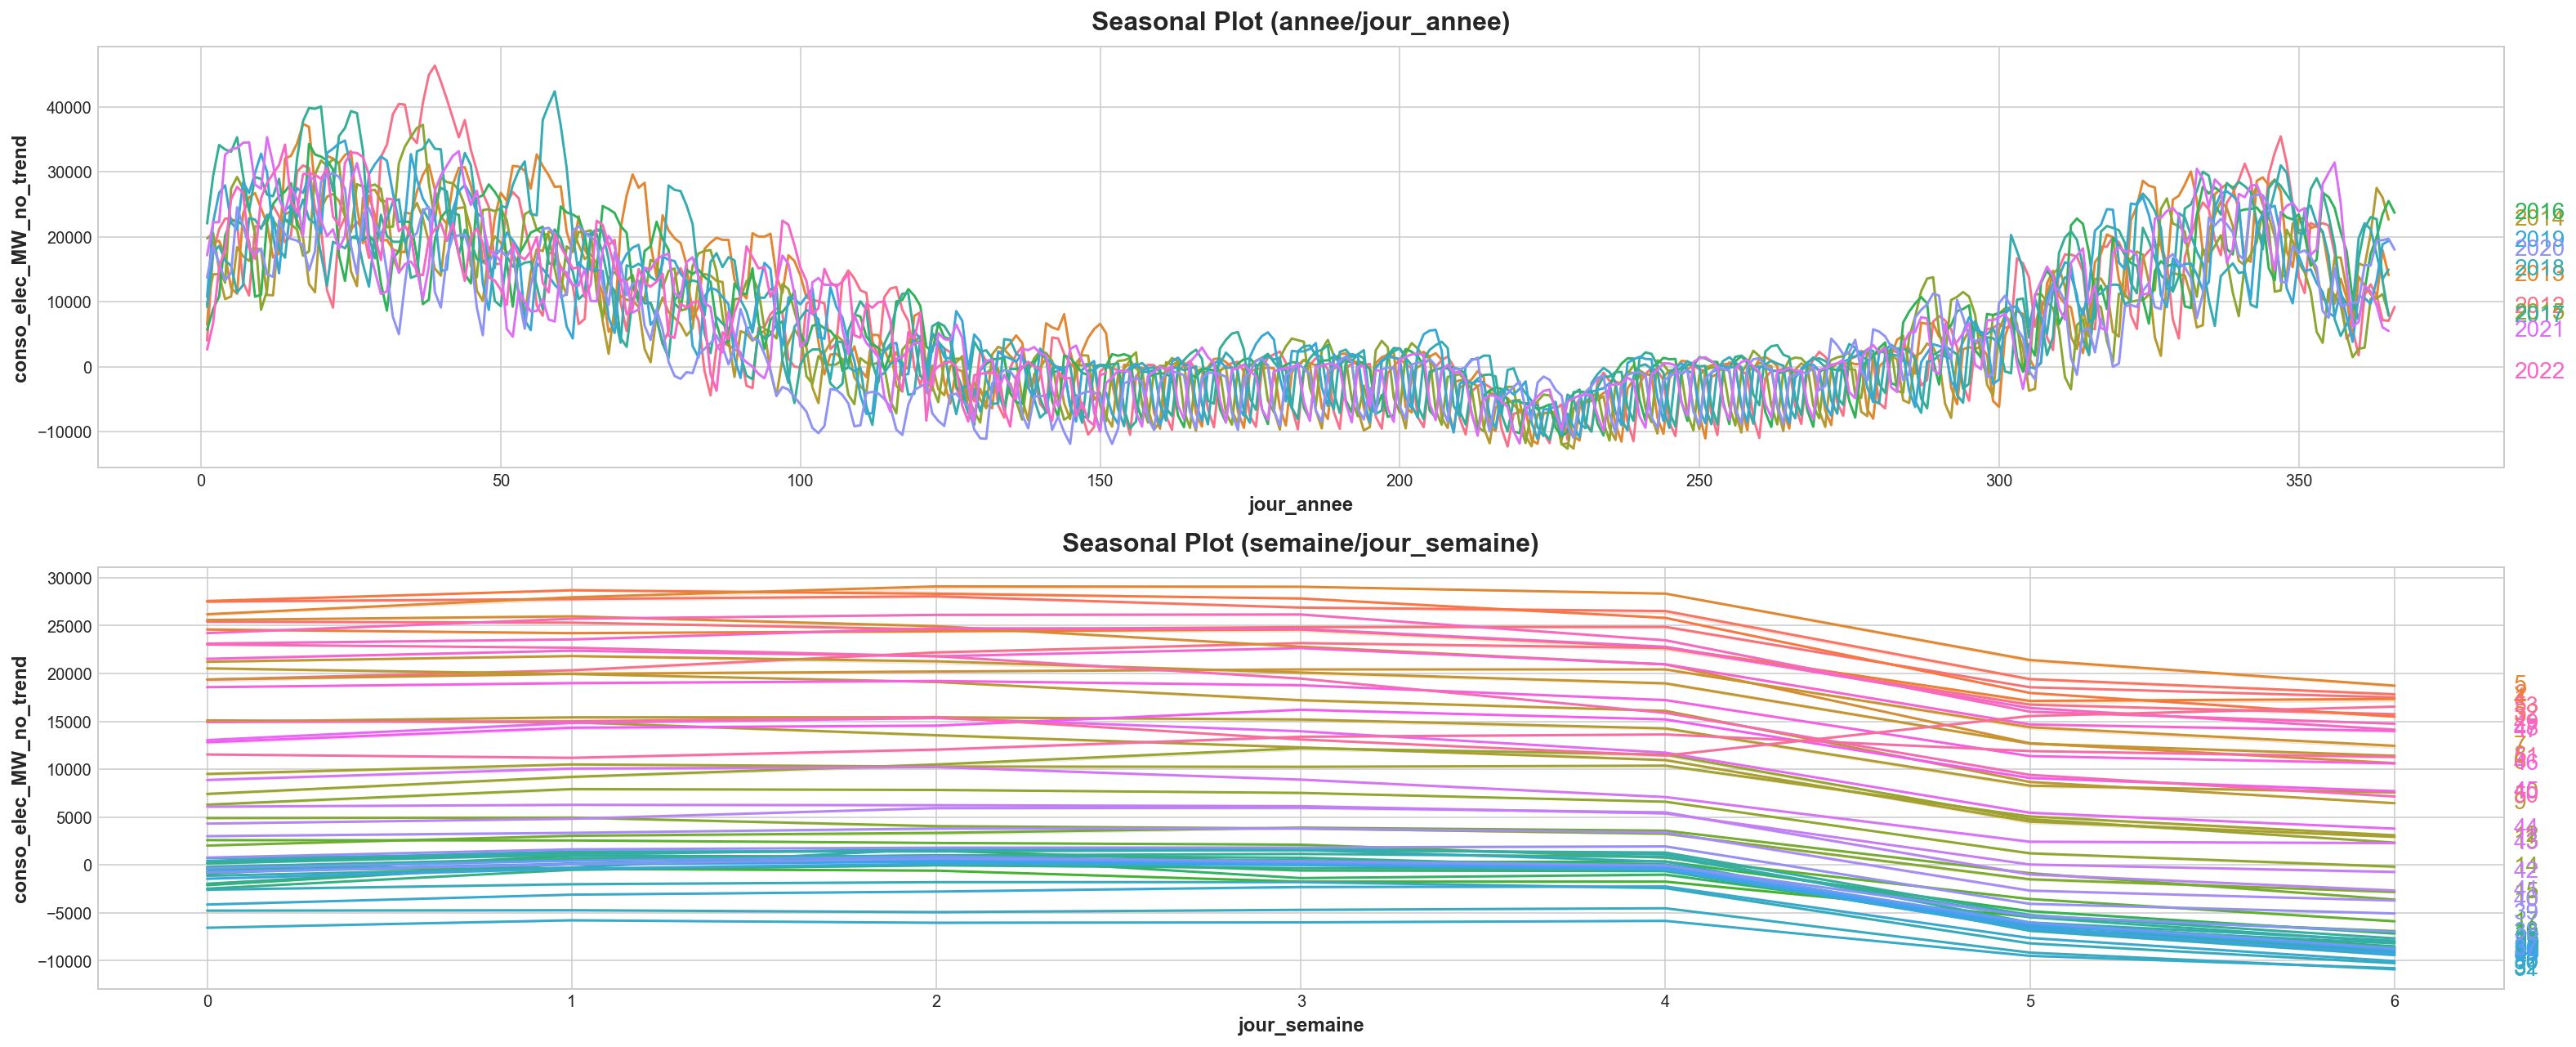

In [15]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(22, 9))
seasonal_plot(X, y="conso_elec_MW_no_trend", period="annee", freq="jour_annee", ax=ax0)
seasonal_plot(X, y="conso_elec_MW_no_trend", period="semaine", freq="jour_semaine", ax=ax1);

Un travail similaire est réalisé pour observation en fonction de l'heure de la journée.<br/>
Mais si il nécessite de se focaliser sur une année.

In [16]:
debut = pd.to_datetime("2021-01-01").tz_localize("Europe/Paris")
fin = pd.to_datetime("2021-12-31 23:30:00").tz_localize("Europe/Paris")

In [17]:
X_heure = df_source[df_source.Date_parsed.between(debut,fin)]\
    .groupby(pd.Grouper(key='Date_parsed', axis=0, freq='H'))\
    .max()

In [18]:
X_heure["jour_annee"] = X_heure.index.dayofyear  # the x-axis (freq)
X_heure["heure"] = X_heure.index.hour  # the x-axis (freq)

In [19]:
X_heure.tail()

,Conso_elec_totale_MW,conso_elec_MW_no_trend,jour_annee,heure
Date_parsed,,,,
2021-12-31 19:00:00+01:00,57764.0,4915.348493,365,19
2021-12-31 20:00:00+01:00,56180.0,3331.379323,365,20
2021-12-31 21:00:00+01:00,53240.0,391.410153,365,21
2021-12-31 22:00:00+01:00,52144.0,-704.543603,365,22
2021-12-31 23:00:00+01:00,54396.0,1547.487227,365,23


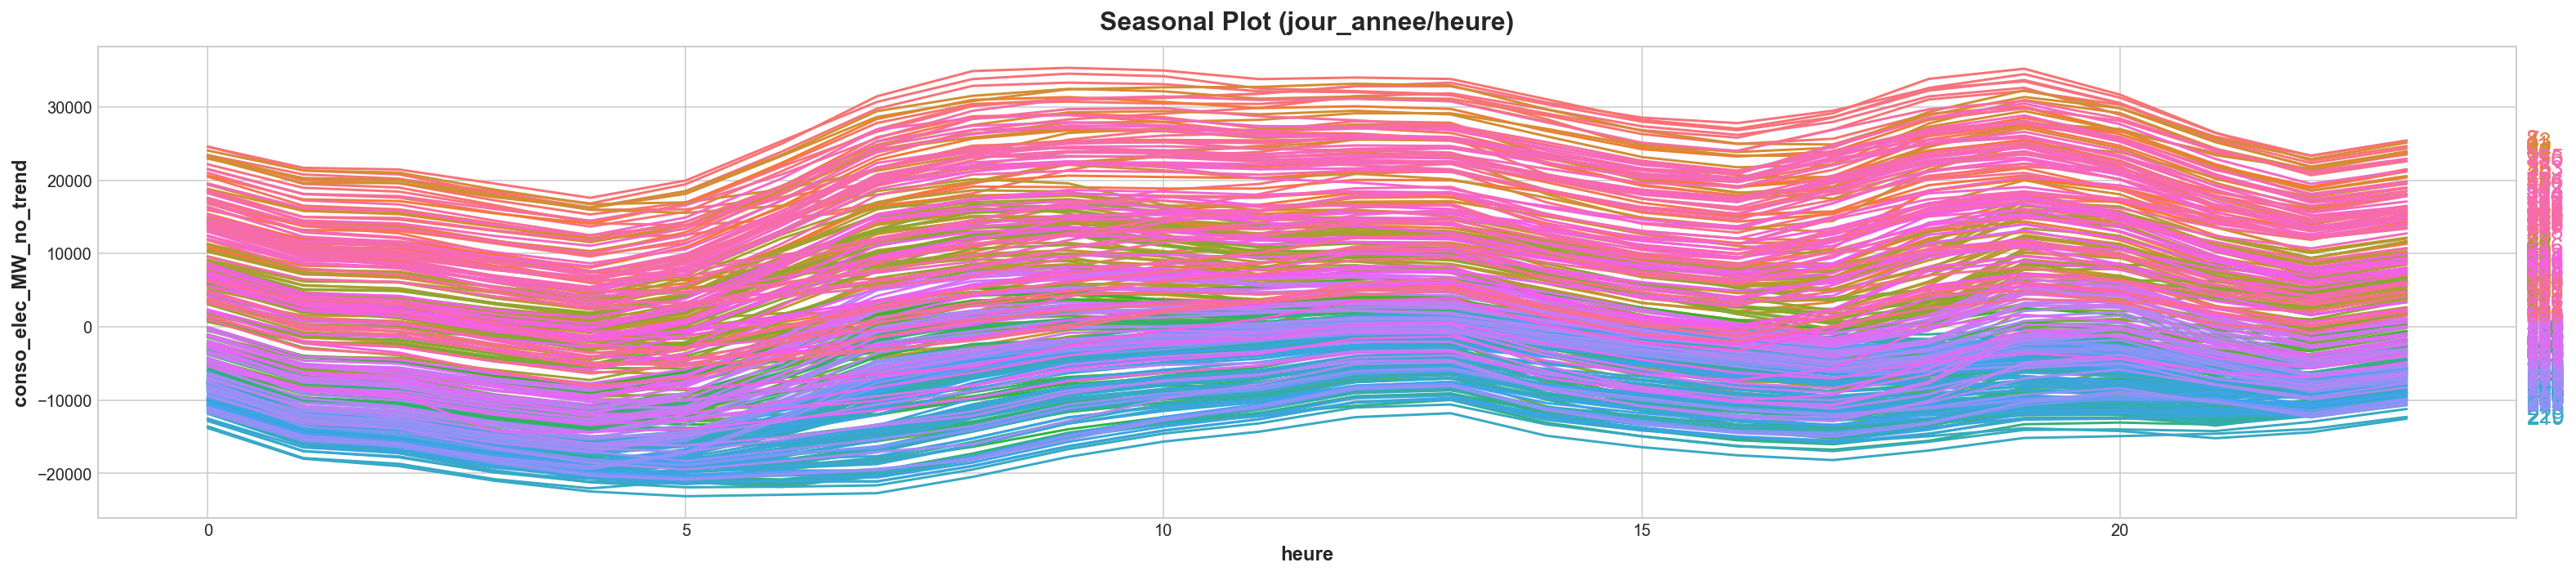

In [20]:
plt.rcParams['figure.figsize'] = [22, 5]
seasonal_plot(X_heure, y="conso_elec_MW_no_trend", period="jour_annee", freq="heure")
plt.show()

#### Conclusion ####
<p>
On observe plusieurs saisonnalités contenues dans notre courbe, de laquelle a été enlevée la tendance :
<li> D'un point de vue annuel, un maximum atteint en Février, puis décroissance pour nouveau pic en Décembre </li>
<li> Au niveau hebdomadaire, une très légère augmentation jusqu'au Mercredi, Jeudi, puis forte décroissance le week-end </li>
<li> En intra-journalier, une vague avec son maximum atteint vers 8h, puis une autre en fin de journée vers 19h</li>
</p>
<p>
Bien que les vagues ne soient pas symétriques ou régulière, ces occurences se répètent avec une grande régularité sur les 10 dernières années.<br/>
Nos séries de Fourier devront donc intégrer l'ensemble de ces saisonalités, afin de produire une courbe sinusoïdale, d'amplitudes voire de fréquence variables, pour modéliser cela le plus fidèlement possible
</p>

# Periodogrammes (Analyse spectrale) #

In [21]:
# Observation Max Quotidien
df_SF = df_source[["Date_parsed","Conso_elec_totale_MW"]].groupby(
    pd.Grouper(key='Date_parsed', axis=0, freq='D')
    ).max()\
    .squeeze()

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

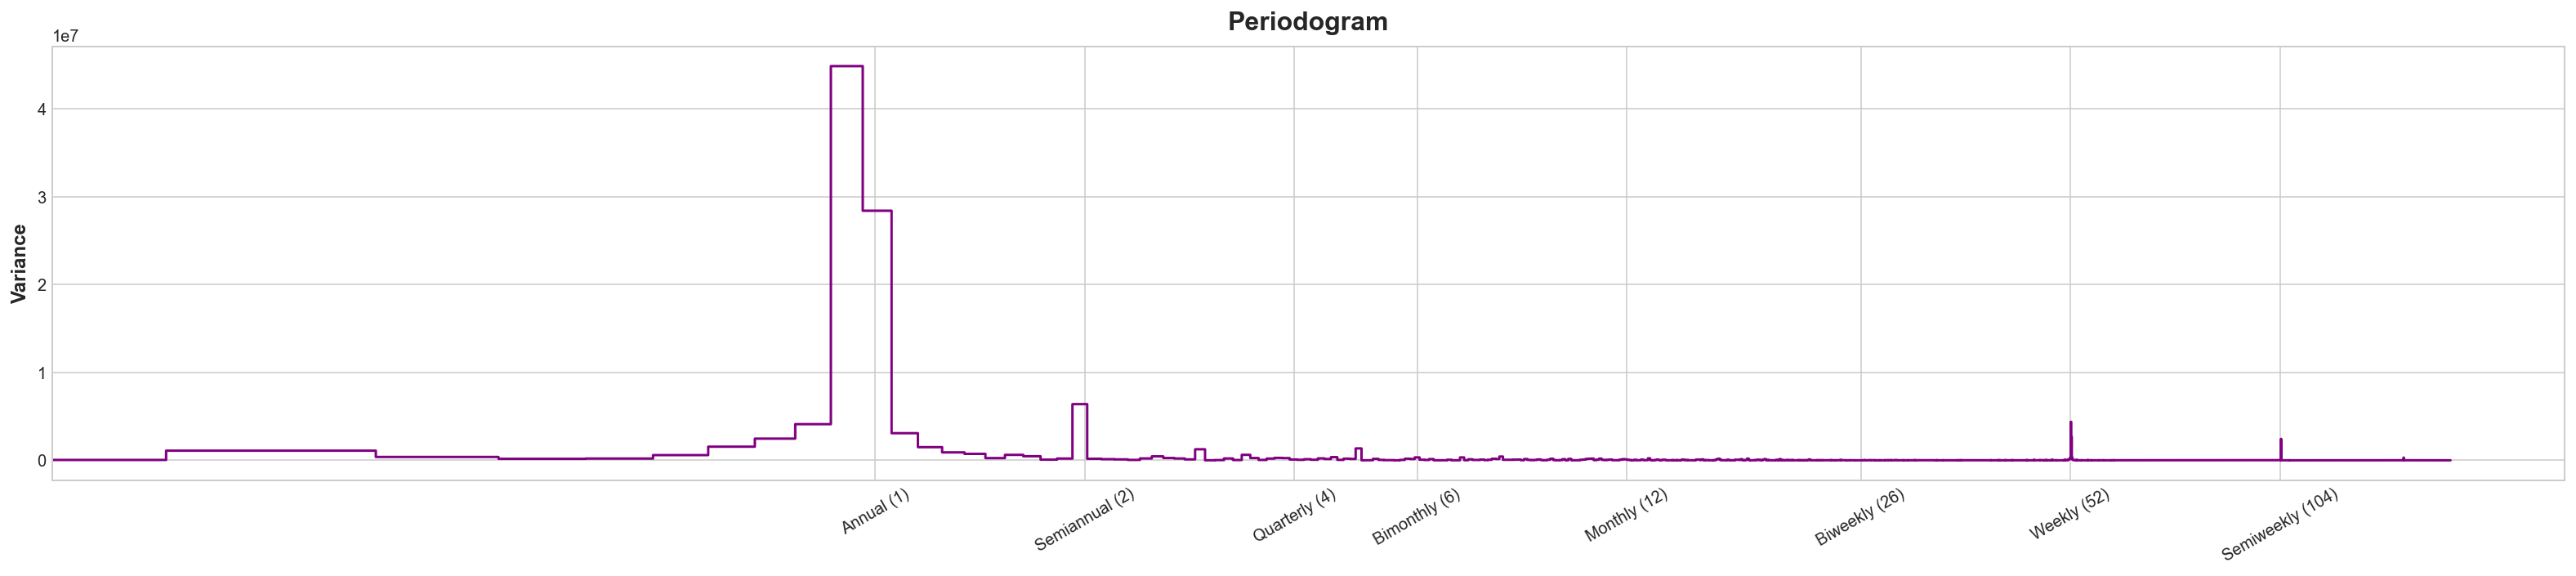

In [22]:
plot_periodogram(df_SF)

In [23]:
# Observation Max Quotidien
df_SF_h = df_source[df_source.Date_parsed.between(debut,fin)]\
    .groupby(pd.Grouper(key='Date_parsed', axis=0, freq='H'))\
    .max()

In [24]:
df_SF_h.interpolate(method='linear', axis=0, inplace=True)

In [25]:
df_SF_h.isna().sum()

Conso_elec_totale_MW      0
conso_elec_MW_no_trend    0
dtype: int64

In [26]:
df_SF_h = df_SF_h.drop(columns=["conso_elec_MW_no_trend"]).squeeze()

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

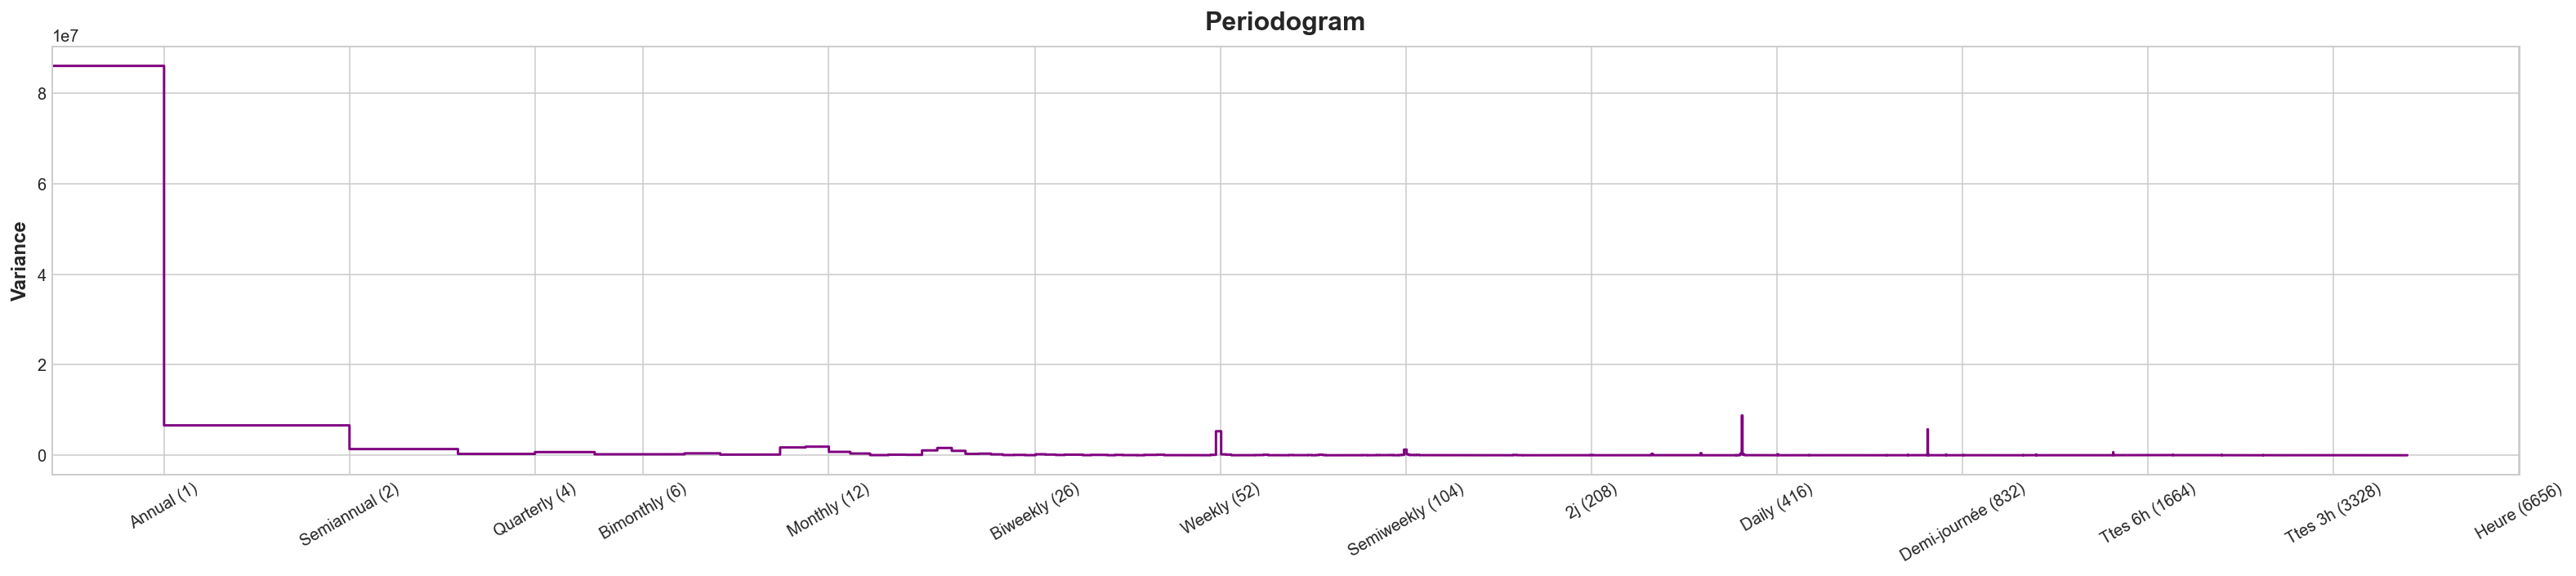

In [27]:
plot_periodogram_h(df_SF_h)

#### Interprétation ####
<p>Les periodogrammes montrent un pic très nettement plus important sur une base annuelle (l'équivalent de tous les hivers, par exemple).<br/>
Voire bi-annuel, bien que cela soit plus difficilement explicable. Et de bien moindre amplitude<br/></p>
<p>Il faut considérer que l'échelle de gauche, qui mesure cette amplitude est logarithmique.<br/>
Autrement dit, l'impact d'une saisonnalité annuelle est de l'ordre de 10^7 (facteur 10 Millions),<br/>
tandis que la saisonnalité observée au jour, ou à la demi-journée est de l'ordre de 10.</p>
<p>On anticipe alors pour la prochaine étape une saisonnalité annuelle principalement.<br/>
Les variations résiduelles qui resteront, hors tendance, hors saisonnalité, seront alors assimilables à du bruit.<br/>
L'analyse et la prédiction de celui-ci se feront, par une autre approche, dans le prochain notebook.</p>

# Série de Fourier et prédiction #

In [145]:
# Similaire à ce qui a été fait pour df_SF
y = df_source[["Date_parsed","Conso_elec_totale_MW"]].groupby(
    pd.Grouper(key='Date_parsed', axis=0, freq='D')
    ).max()

In [146]:
# On ressort l'index pour en supprimer la timezone, DeterministicProcess ne marche pas sinon
y.reset_index(inplace=True)

In [147]:
# Suppression de la tz, et remise en index
y['Date_parsed'] = pd.to_datetime(y['Date_parsed'].dt.date)
y.set_index('Date_parsed', inplace=True)

In [148]:
y.head()

,Conso_elec_totale_MW
Date_parsed,
2012-01-01,59610.0
2012-01-02,73262.0
2012-01-03,76698.0
2012-01-04,78337.0
2012-01-05,78351.0


In [149]:
fourier = CalendarFourier(freq="A", order=2)  # 2 sin/cos pairs for "A"nnual seasonality

In [150]:
index = pd.period_range("2012-01-01", freq="D", periods=3804)

In [151]:
dp = DeterministicProcess(
    index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,              # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True                   # drop terms to avoid collinearity
)

In [152]:
X = dp.in_sample()  # create features for dates in tunnel.index

In [153]:
X.tail()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
2022-05-27,1.0,3800.0,0.0,0.0,0.0,0.0,1.0,0.0,0.587785,-0.809017,-0.951057,0.309017
2022-05-28,1.0,3801.0,0.0,0.0,0.0,0.0,0.0,1.0,0.573772,-0.819015,-0.939856,0.341571
2022-05-29,1.0,3802.0,0.0,0.0,0.0,0.0,0.0,0.0,0.559589,-0.828770,-0.927542,0.373720
2022-05-30,1.0,3803.0,1.0,0.0,0.0,0.0,0.0,0.0,0.545240,-0.838280,-0.914128,0.405426
2022-05-31,1.0,3804.0,0.0,1.0,0.0,0.0,0.0,0.0,0.530730,-0.847541,-0.899631,0.436651


In [154]:
# Isolation de la cible pour entraînement puis prédiction
y = y.squeeze()
y

Date_parsed
2012-01-01    59610.0
2012-01-02    73262.0
2012-01-03    76698.0
2012-01-04    78337.0
2012-01-05    78351.0
               ...   
2022-05-27    47213.0
2022-05-28    44486.0
2022-05-29    43756.0
2022-05-30    51405.0
2022-05-31    51851.0
Name: Conso_elec_totale_MW, Length: 3804, dtype: float64

In [155]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

In [156]:
y_pred = pd.Series(model.predict(X), index=y.index)

In [159]:
# 7 mois -> 210j
X_fore = dp.out_of_sample(steps=547)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

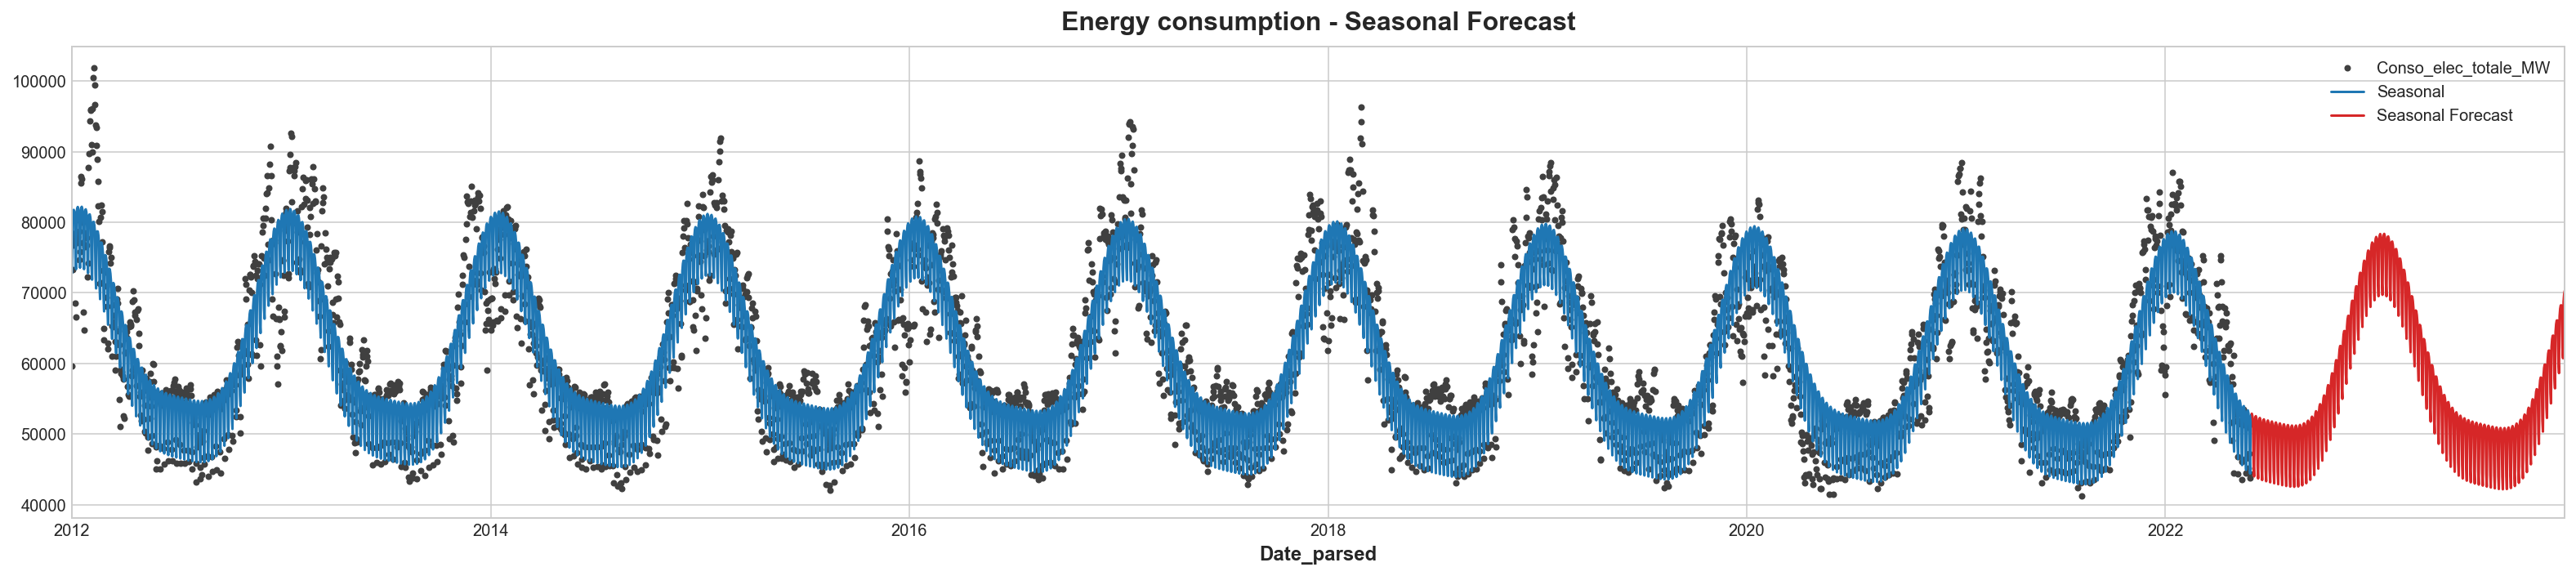

In [160]:

ax = y.plot(color='0.25', style='.', title="Energy consumption - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()